In [285]:
import re
import string
from statistics import mean, median, mode

import pandas as pd
import numpy as np
import nltk

from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, LSTM, Bidirectional, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flavi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv("D:\Data for python\datasets\cyber bullying tweets\cyberbullying_tweets.csv") 

In [4]:
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [6]:
df.cyberbullying_type.unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [7]:
bullying_type = { "not_cyberbullying":0, "gender":1, "religion":2, "age":3, "ethnicity":4, "other_cyberbullying":5}

In [8]:
df.cyberbullying_type = df.cyberbullying_type.apply(lambda x: bullying_type[x])

In [9]:
df.tweet_text = df.tweet_text.apply(lambda x: x.lower())

In [10]:
df

,tweet_text,cyberbullying_type
0,"in other words #katandandre, your food was cra...",0
1,why is #aussietv so white? #mkr #theblock #ima...,0
2,@xochitlsuckkks a classy whore? or more red ve...,0
3,"@jason_gio meh. :p thanks for the heads up, b...",0
4,@rudhoeenglish this is an isis account pretend...,0
...,...,...
47687,"black ppl aren't expected to do anything, depe...",4
47688,turner did not withhold his disappointment. tu...,4
47689,i swear to god. this dumb nigger bitch. i have...,4
47690,yea fuck you rt @therealexel: if youre a nigge...,4


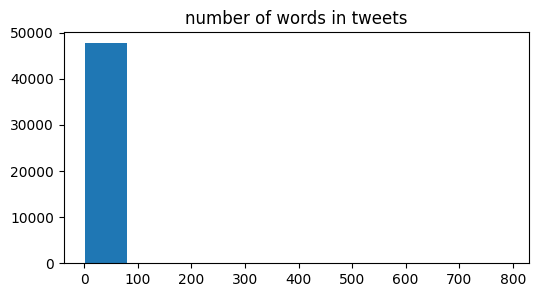

In [302]:
sizes = df.tweet_text.apply(lambda x: len(x.split())).tolist()
plt.figure(figsize=(6, 3))
plt.hist(sizes)
plt.title("number of words in tweets")
plt.show()

preparing GLOVE word embeddings

In [65]:
EMBED_DIM = 25

glove_path = fr"D:\Data for python\datasets\glove.twitter.27B\glove.twitter.27B.{EMBED_DIM}d.txt"

def dict_from_embeddings(filename):
    embeddings = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = line.split(' ')
            try:
                embeddings[line[0]] = np.array(line[1:], dtype=float)
            except:
                continue
    return embeddings

In [66]:
embedding_dict = dict_from_embeddings(glove_path)

In [67]:
len(embedding_dict)

1193515

presence of special characters.
what to do with them?

In [68]:
# hashtags
ht = df[df.tweet_text.str.contains("#")].shape[0] / df.shape[0]
mentions = df[df.tweet_text.str.contains("@")].shape[0] / df.shape[0]

print(f"hashtags: {round(ht * 100,2 )}%")
print(f"mentions: {round(mentions *100,2)} %")

hashtags: 14.7%
mentions: 38.03 %


what if we swap @ to "mentions " and # to "about" ?

In [69]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def clean_tweet(tweet: str):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Replace user mentions and hashtags with special tokens
    tweet = tweet.replace("@", "mentions ")
    tweet = tweet.replace("#", "about ")
    # remove stop words
    tweet = " ".join([word for word in tweet.split()
                     if word not in stop_words])
    # remove remaining punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    return tweet


def lemmatize_word(words):
    return [lemmatizer.lemmatize(word) for word in words if word not in stop_words]


def pad_sequence(sequence, max_length):
    if len(sequence) >= max_length:
        return sequence[:max_length]
    else:
        return sequence + [0]*(max_length - len(sequence))


def vectorize_sequence(sequence, embeddings_dict):
    return np.array([embeddings_dict.get(word, np.zeros(EMBED_DIM, dtype=np.float32)) for word in sequence])


def vectorize_tweet(tweet, embeddings_dict, max_length):
    # clean
    clean = clean_tweet(tweet)
    # Lemmatize tokens
    lemmatized_tokens = lemmatize_word(clean.split())
    # Pad sequence
    padded_tweet = pad_sequence(lemmatized_tokens, max_length)
    # Vectorize sequence
    vectorized_tweet = vectorize_sequence(padded_tweet, embeddings_dict)
    return vectorized_tweet


In [176]:
# Preprocess tweets
MAX_LEN = 50 # int(mean([len(tweet.split()) for tweet in x]))

preprocessed_tweets = [vectorize_tweet(tweet, embedding_dict, MAX_LEN) for tweet in df.tweet_text]
preprocessed_tweets = np.array(preprocessed_tweets)

In [177]:
preprocessed_tweets[0].shape

(50, 25)

In [178]:
SPLIT_CUT =  38000   # the size of the training data

x = preprocessed_tweets 
y = df.cyberbullying_type

x_train_full, x_test, y_train_full, y_test =  train_test_split(x, y, test_size=0.1)          
x_train, x_valid =  x_train_full[:SPLIT_CUT], x_train_full[SPLIT_CUT:]   
y_train, y_valid =  y_train_full[:SPLIT_CUT], y_train_full[SPLIT_CUT:]


Models

In [179]:
input_dim = len(embedding_dict)
embedding_dim = EMBED_DIM
max_length = MAX_LEN
num_classes = len(df.cyberbullying_type.unique())

model = Sequential()
model.add(Input(shape=(max_length, embedding_dim)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [180]:
ephocs_ = 10
history = model.fit(x_train, to_categorical(y_train), validation_data=(x_valid, to_categorical(y_valid)), epochs=ephocs_)

Epoch 1/10
1188/1188 [==============================] - 66s 51ms/step - loss: 0.7950 - accuracy: 0.6939 - val_loss: 0.5246 - val_accuracy: 0.7794
Epoch 2/10
1188/1188 [==============================] - 60s 51ms/step - loss: 0.5426 - accuracy: 0.7846 - val_loss: 0.4629 - val_accuracy: 0.8125
Epoch 3/10
1188/1188 [==============================] - 63s 53ms/step - loss: 0.4885 - accuracy: 0.8039 - val_loss: 0.4525 - val_accuracy: 0.8167
Epoch 4/10
1188/1188 [==============================] - 58s 49ms/step - loss: 0.4585 - accuracy: 0.8159 - val_loss: 0.4347 - val_accuracy: 0.8261
Epoch 5/10
1188/1188 [==============================] - 61s 51ms/step - loss: 0.4392 - accuracy: 0.8218 - val_loss: 0.4236 - val_accuracy: 0.8253
Epoch 6/10
1188/1188 [==============================] - 60s 50ms/step - loss: 0.4208 - accuracy: 0.8297 - val_loss: 0.4085 - val_accuracy: 0.8369
Epoch 7/10
1188/1188 [==============================] - 60s 51ms/step - loss: 0.4062 - accuracy: 0.8335 - val_loss: 0.4038 -

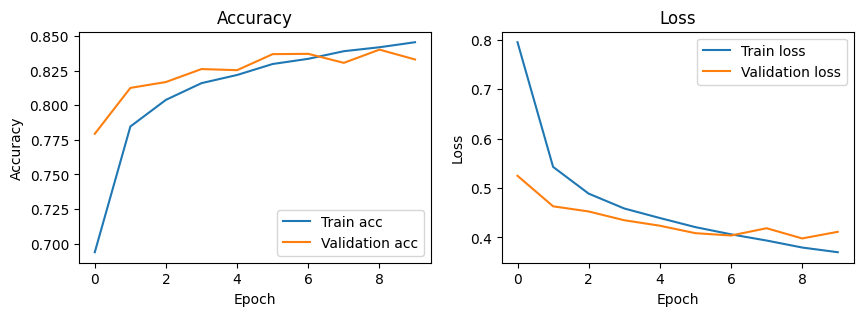

In [181]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(history.history["accuracy"], label="Train acc")
axs[0].plot(history.history["val_accuracy"], label="Validation acc")
axs[0].set_title("Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(history.history["loss"], label="Train loss")
axs[1].plot(history.history["val_loss"], label="Validation loss")
axs[1].set_title("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.show()


In [182]:
preds = model.predict(x_test)
preds_winners = [np.argmax(pred) for pred in preds]

150/150 [==============================] - 4s 18ms/step


In [183]:
accuracy_score(y_test, preds_winners)

0.8362683438155136

conslusion:  83% accuracy. But I tried the model on fake tweets and noticed that it doesn't capture more subtle forms of bullying, paying too much attention to keywords instead of meanings. It could be used as a simple flagging system for inspection by humans or a better model.